# Beam Search optimization

The code for beam search can be found in the DecoderRNNwithAttention class of models.py
The lineprofiler for the optimized and unoptimized code can be found in the project google drive

In [1]:
import argparse, os
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pickle
import numpy as np
from utils import Vocabulary, Custom_Flickr30k, collate_fn
import models
from imp import reload
reload(models)
from models import EncoderCNN, DecoderRNNwithAttention
from beam import print_beam_outputs
%load_ext line_profiler


In [2]:
vocab = pickle.load(open('vocab.p', 'rb'))
NUM_WORKERS = 4
CROP_SIZE = 256
NUM_PIXELS = 64
ENCODER_SIZE = 2048

val_transform = transforms.Compose([
            transforms.CenterCrop(CROP_SIZE),
            transforms.ToTensor(),
            transforms.Normalize((0.444, 0.421, 0.385),
                                 (0.285, 0.277, 0.286))])
val_loader = torch.utils.data.DataLoader(
            dataset=Custom_Flickr30k('../flickr30k-images','../flickr30k-captions/results_20130124.token', vocab, transform=val_transform, train=False),
            batch_size=16,
            shuffle=False,
            num_workers=NUM_WORKERS,
            collate_fn=collate_fn)

In [3]:
encoder = EncoderCNN() 
decoder = DecoderRNNwithAttention(vocab, 512, 1, 512, ENCODER_SIZE, NUM_PIXELS, 0.5)   
model = torch.load('better_model.pth.tar', map_location=torch.device('cpu')) 
encoder.load_state_dict(model['encoder']) 
decoder.load_state_dict(model['decoder']) 

<All keys matched successfully>

In [4]:
# obtain a batch of sample features, images, and captions
features = None
imgs = None
caps = None
for i, (images, captions, lengths) in enumerate(val_loader):
    if i > 1:
        break
    features = encoder(images)
    imgs = images
    caps = captions

In [5]:
%lprun -f decoder.beam_sample beams =  decoder.beam_sample(features, imgs=images, targets = captions, beam_size=3)

## Improvements to the Beam Search implementation:

By looking at the results of the line profiler, it is clear that the main bottleneck during Beam Search is the attention of the features. While this cannot be optimized through methods learned in class, other parts of the function were optimized using such methods.

### Improvement 1: List comprehension during top candidate search
During beam search at step $t$ of the search, we must choose the top $k$ sequences out of a list of $k^2$ sequences, where $k$ is the number of beams we look through. Those $k^2$ sequences are built from the top $k$ sequences from time $t-1$, where for each sequence, the top $k$ are chosen.
An earlier implementation of the algorithm added sequences one by one and removed them one by one, and looked like the following:
```python
1 for k in range(beam_size):
2     for j in range(batch_size):
3         next_candidates[j].append(
4             (beam.scores[j].item() + topv[j][k].item(),
5              topi[j][k].item(),
6              beam.seq[j] + [str(topi[j][k].item())])
7         )
8      if len(next_candidates[j]) > beam_size: 
9          next_candidates[j].remove(min(next_candidates[j]))
```
Lines 9 and 10 were removed and replaced (outside of the for-loop) with a list-comprehension removal like so

```{python}
next_candidates = [sorted(next_cand)[-beam_size:] for next_cand in next_candidates]
```

During a lineprofile run comparing these two implementations using a batch of 16 images, the first took .0013093 seconds and the second took .0000919 seconds, or 14 times faster.

### Improvement 2: Adding candidates to candidate list through list comprehension

To improve lines 1-7 in the above code, we replaced the outer for loop with list comprehension. It looks like the following:

```python
for j in range(batch_size):
    next_candidates[j] += [(beam.scores[j].item()+topv[j][k].item(),
                            topi[j][k].item(), beam.seq[j] + [str(topi[j][k].item())]) for k in range(beam_size)]
```

While not as effective as the previouse improvement, this improvement, according to line profiler, increased the speed of this computation by about 1.6 times.

### Beam search example

Below shows captions created with 1 to 11 beams. 1 beam is essentially a greedy search algorithm. Since the model for this example is not fully trained, we are not receiving amazing results. However, we see some improvement by improving the number of beams

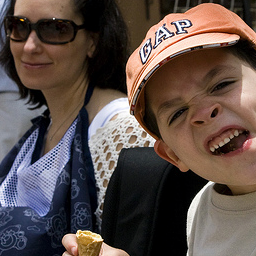

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> a man in a shirt is playing a a street in the background and a man in a blue shirt


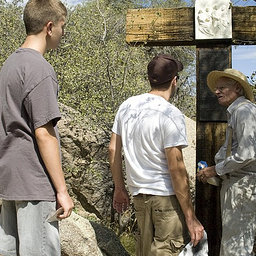

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> a man in a blue shirt and a red shirt and a a blue shirt is on a table with


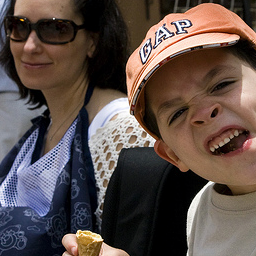

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> a man in a blue and a <unk> with a on a bench in a red a a <unk> a
<start> a man in a blue and a <unk> with a on a bench in a red a a <unk> is


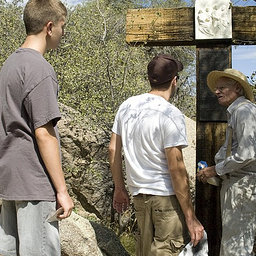

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> a man in a red shirt and the a <unk> a man with his head is standing in the street
<start> a man in a red shirt and the a <unk> a man with his head is standing in a blue


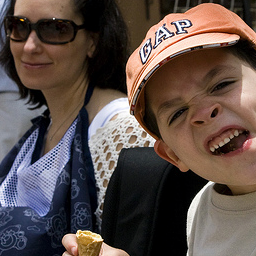

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> a is is playing in the is a white and and a blue on a sidewalk on the <unk> a
<start> a is is playing in the is a white and and a blue on a sidewalk on the <unk> in
<start> a is is playing in the is a white and and a blue on a sidewalk on the <unk> is


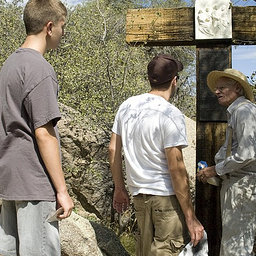

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> two women are in a street officer is playing in the floor is is a table with a man in
<start> two women are in a street officer is playing in the floor is is a table with a man is
<start> two women are in a street officer is playing in the floor is is a table with a man and


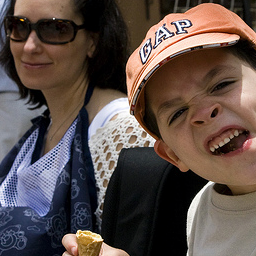

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> a is on the <unk> a <unk> bench in the sidewalk on a blue and the <unk> man and a
<start> a is on the <unk> a <unk> bench in the sidewalk on a blue and the <unk> man and is
<start> a is on the <unk> a <unk> bench in the sidewalk on a blue and the <unk> man and the
<start> a is on the <unk> a <unk> bench in the sidewalk on a blue and the <unk> man and in


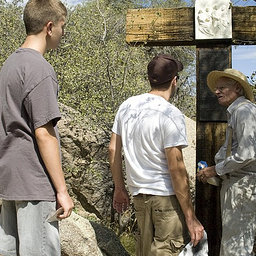

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> the a <unk> in a book and is a red hair is a red is wearing a <unk> on a
<start> the a <unk> in a book and is a red hair is a red is wearing a <unk> on the
<start> the a <unk> in a book and is a red hair is a red is wearing a <unk> on his
<start> the a <unk> in a book and is a red hair is a red is wearing a <unk> on on


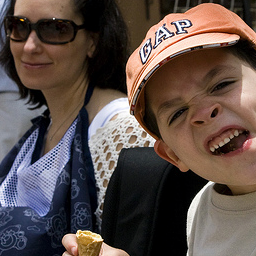

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> a <unk> of <unk> a newspaper of a <unk> and <unk> in the floor in the blue and and a
<start> a <unk> of <unk> a newspaper of a <unk> and <unk> in the floor in the blue and and the
<start> a <unk> of <unk> a newspaper of a <unk> and <unk> in the floor in the blue and and his
<start> a <unk> of <unk> a newspaper of a <unk> and <unk> in the floor in the blue and and her
<start> a <unk> of <unk> a newspaper of a <unk> and <unk> in the floor in the blue and and sunglasses


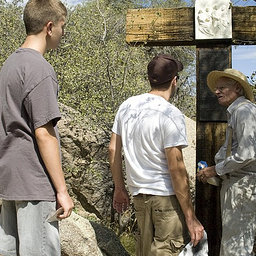

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> a in blue red shirt and a is and blue a blue and with a woman and the <unk> a
<start> a in blue red shirt and a is and blue a blue and with a woman and the <unk> on
<start> a in blue red shirt and a is and blue a blue and with a woman and the <unk> in
<start> a in blue red shirt and a is and blue a blue and with a woman and the <unk> of
<start> a in blue red shirt and a is and blue a blue and with a woman and the <unk> and


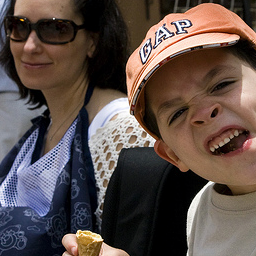

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> a man a white and on a green the the is a blue a <unk> is is a in a
<start> a man a white and on a green the the is a blue a <unk> is is a and a
<start> a man a white and on a green the the is a blue a <unk> is is a in is
<start> a man a white and on a green the the is a blue a <unk> is is a in the
<start> a man a white and on a green the the is a blue a <unk> is is a in and
<start> a man a white and on a green the the is a blue a <unk> is is a in shirt


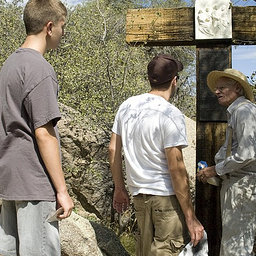

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> a woman is the a with with <unk> with a woman is the <unk> of man is his and a
<start> a woman is the a with with <unk> with a woman is the <unk> of man is his and the
<start> a woman is the a with with <unk> with a woman is the <unk> of man is his and in
<start> a woman is the a with with <unk> with a woman is the <unk> of man is his and white
<start> a woman is the a with with <unk> with a woman is the <unk> of man is his and man
<start> a woman is the a with with <unk> with a woman is the <unk> of man is his and 

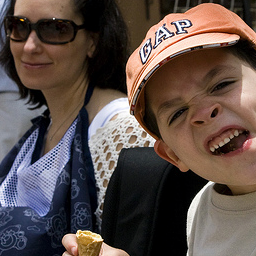

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> a large man is standing and people a blue man is playing the beach blue and the is is standing
<start> a large man is standing and people a blue man is playing the beach blue and the is is sitting
<start> a large man is standing and people a blue man is playing the beach blue and the is is playing
<start> a large man is standing and people a blue man is playing the beach blue and the is is walking
<start> a large man is standing and people a blue man is playing the beach blue and the is is holding
<start> a large man is standing and people a blue man is playing 

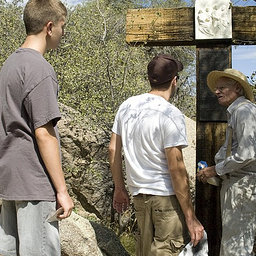

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> two <unk> a a guitar and <unk> a street a red shirt and the <unk> and a building on a
<start> two <unk> a a guitar and <unk> a street a red shirt and the <unk> and a building on the
<start> two <unk> a a guitar and <unk> a street a red shirt and the <unk> and a building on his
<start> two <unk> a a guitar and <unk> a street a red shirt and the <unk> and a building on on
<start> two <unk> a a guitar and <unk> a street a red shirt and the <unk> and a building on her
<start> two <unk> a a guitar and <unk> a street a re

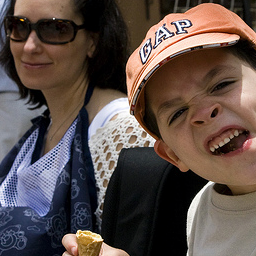

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> a man is a <unk> a large and on a and and and the a <unk> of and the a
<start> a man is a <unk> a large and on a and and and the a <unk> of and the his
<start> a man is a <unk> a large and on a and and and the a <unk> of and the the
<start> a man is a <unk> a large and on a and and and the a <unk> of and the her
<start> a man is a <unk> a large and on a and and and the a <unk> of and the <unk>
<start> a man is a <unk> a large and on a and and and the a <unk> of and the blue
<start> a man is a <unk> a large and on a and and and the a <unk> of and the cigarette
<s

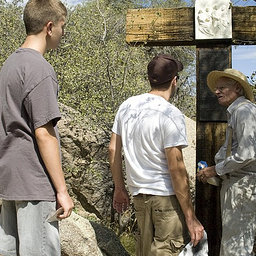

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> a on his head in red is the other and a is a the <unk> and water is a man
<start> a on his head in red is the other and a is a the <unk> and water is a woman
<start> a on his head in red is the other and a is a the <unk> and water is a is
<start> a on his head in red is the other and a is a the <unk> and water is a with
<start> a on his head in red is the other and a is a the <unk> and water is a and
<start> a on his head in red is the other and a is a the <unk> and water is a in
<start> a on his head in red is the 

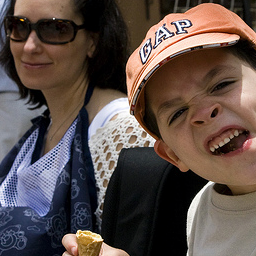

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> two child on street man in the is a of and with the a <unk> while another with the a
<start> two child on street man in the is a of and with the a <unk> while another with the shirt
<start> two child on street man in the is a of and with the a <unk> while another with the is
<start> two child on street man in the is a of and with the a <unk> while another with the the
<start> two child on street man in the is a of and with the a <unk> while another with the and
<start> two child on street man in the is a of and with the a <unk> while another with the pants
<star

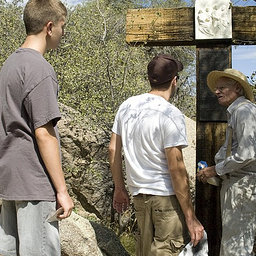

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> there are is a street and the table a red hair and her in her on a <unk> is a
<start> there are is a street and the table a red hair and her in her on a <unk> is in
<start> there are is a street and the table a red hair and her in her on a <unk> is is
<start> there are is a street and the table a red hair and her in her on a <unk> is on
<start> there are is a street and the table a red hair and her in her on a <unk> is and
<start> there are is a street and the table a red hair and her in her on a <unk> is the
<start

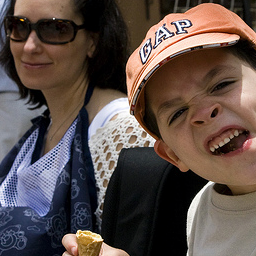

Target Captions:
a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him
a woman sits with a boy in an orange hat with a cookie in his hand as he makes a funny face
a lady and a boy who is having ice cream are sitting together
a child finishing an ice cream cone mugs for the camera
a boy in a gap hat is making a silly face

Predicted Captions:
<start> two <unk> is standing white <unk> and blue in an <unk> with <unk> of and woman and green while a
<start> two <unk> is standing white <unk> and blue in an <unk> with <unk> of and woman and green <unk> a
<start> two <unk> is standing white <unk> and blue in an <unk> with <unk> of and woman and green while the
<start> two <unk> is standing white <unk> and blue in an <unk> with <unk> of and woman and green <unk> the
<start> two <unk> is standing white <unk> and blue in an <unk> with <unk> of and woman and green <unk> his
<start> two <unk> is standing white <unk> and

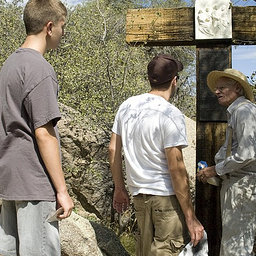

Target Captions:
three male figures of different ages stand next to some rocks as they are <unk> by a large upright wooden cross
two young men clutch rags in their hands as a elderly man tells them how to clean the large cross
two younger boys are standing in front of an older man in front of a large wooden cross
two young men and an older man are standing in front of a big wooden cross
two men listening intently to a local underneath a landmark

Predicted Captions:
<start> two <unk> a <unk> and man is the a the blue is a <unk> a blue in and sidewalk on
<start> two <unk> a <unk> and man is the a the blue is a <unk> a blue in and sidewalk with
<start> two <unk> a <unk> and man is the a the blue is a <unk> a blue in and sidewalk in
<start> two <unk> a <unk> and man is the a the blue is a <unk> a blue in and sidewalk while
<start> two <unk> a <unk> and man is the a the blue is a <unk> a blue in and sidewalk and
<start> two <unk> a <unk> and man is the a the blue is a <unk> a blue in and s

In [6]:
for i in range(1,11):
    beams = decoder.beam_sample(features, imgs=images, targets = captions, beam_size=i)
    print_beam_outputs(beams, vocab, num_to_print=2)